In [35]:
from mynn import *

prefix = "../"
θ = np.load(prefix+"random_8_direct_theta.npy")   
κ = np.load(prefix+"random_8_direct_omega.npy")
   
θ_train, κ_train = θ[:, 0::2].transpose(), κ[:, :,  0::2]
θ_test,  κ_test  = θ[:, 1::2].transpose(), κ[:, :,  1::2]


coeff_scale = 1.0
# load data 

N_data, N_θ  =  θ_train.shape
N_x, N_y, N_data = κ_train.shape

N_tot = N_x*N_y

L = 2*np.pi
assert(N_x == N_y)
Δx = L/(N_x - 1)

input_train  = np.zeros((N_data * N_tot, (N_θ + 2)), dtype=np.float32) # θ, x, y
output_train = np.zeros((N_data * N_tot), dtype=np.float32)

xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

# test
i = 20
j = 40
assert(X[i, j] == i*Δx and Y[i, j] == j*Δx)

X_tot = X.reshape(N_tot)
Y_tot = Y.reshape(N_tot)

for i in range(N_data):
    d_range = range(i*N_tot, (i + 1)*N_tot)
    input_train[d_range , 0:N_θ]     = θ_train[i]
    input_train[d_range ,   N_θ]     = X_tot
    input_train[d_range ,   N_θ + 1] = Y_tot 
    output_train[d_range]            = κ_train[:, :, i].reshape(N_tot) * coeff_scale
    



x_train = torch.from_numpy(input_train) 
y_train = torch.from_numpy(output_train).unsqueeze(-1)

In [30]:
ds = DirectData(X=x_train, y=y_train)
ds = DataLoader(ds, batch_size=256, shuffle=True)



# training with adam
model = DirectKernelNet(N_θ)
# model = torch.load("DirectKernelNet_1.model")

loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

n_epochs = 0
for epoch in range(n_epochs):
    
    for ix, (_x, _y) in enumerate(ds):
    
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(_x)

        # Compute and print loss.
        loss = loss_fn(y_pred, _y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
    if epoch % 10 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelNet_1.model")

	
# save the model
torch.save(model, "DirectKernelNet_1.model")
# model = torch.load("DirectKernelNet_1.model")


## Training error 

Average training error is  1.0067769106824538


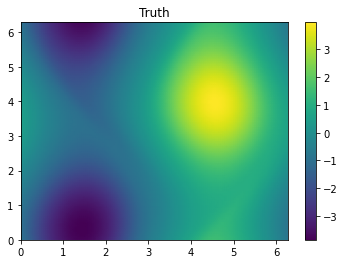

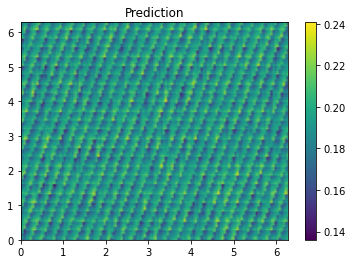

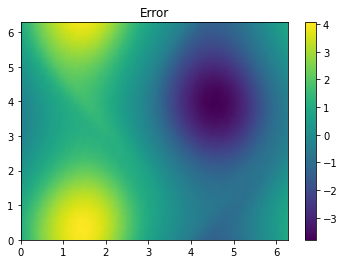

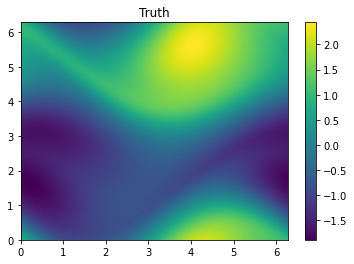

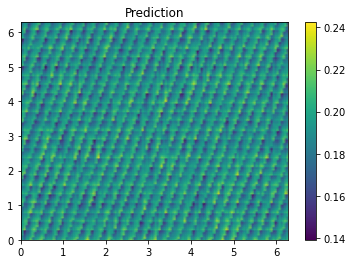

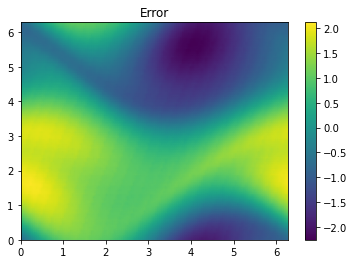

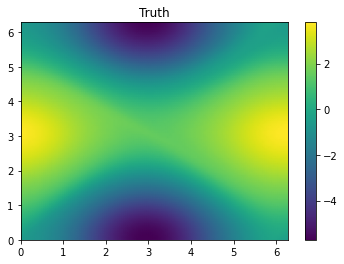

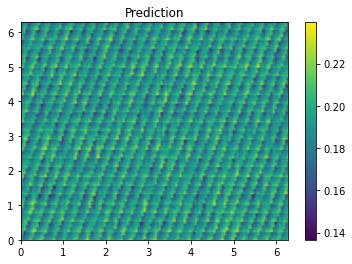

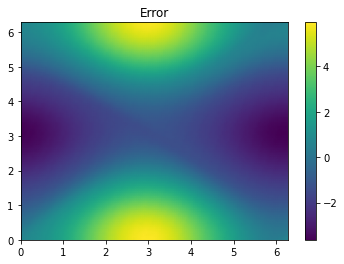

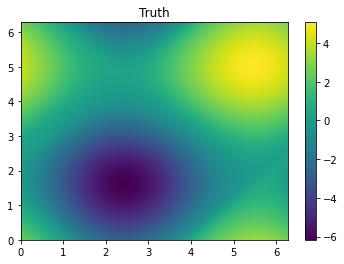

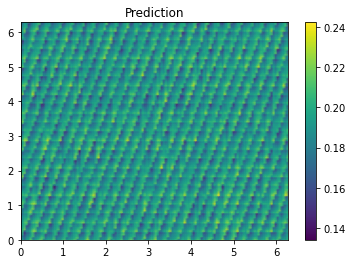

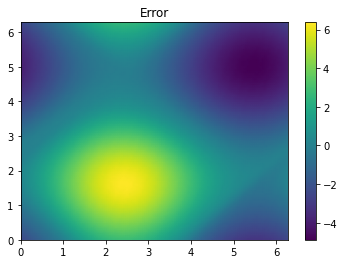

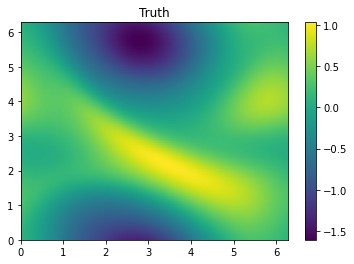

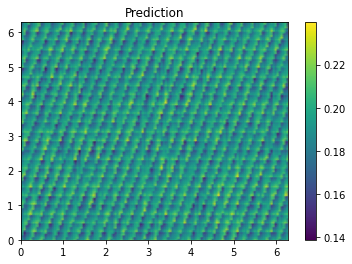

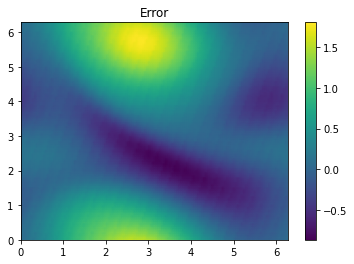

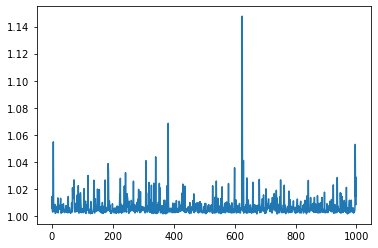

In [31]:
######################################################
N_θ, N_data  =  θ_train.shape
N_x, N_y, N_data = κ_train.shape


output_train = model(torch.from_numpy(input_train)).detach().numpy()
κ_pred = output_train.reshape(N_x, N_y, N_data)/coeff_scale


train_ids = np.arange(0, N_data)
errors = np.zeros(N_data)
for train_id in train_ids:

    errors[train_id] =  np.linalg.norm(κ_pred[:, :, train_id] - κ_train[:, :, train_id])/np.linalg.norm(κ_train[:, :, train_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if train_id %249 == 0:
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_train[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % train_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % train_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, train_id] - κ_train[:, :, train_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Average training error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)



## Test error 

In [43]:
model = torch.load("DirectKernelNet_1.model")

N_data_test = len(θ_test)
input_test = np.zeros((N_data_test*N_tot, (N_θ + 2)), dtype=np.float32) # θ, x, y

for i in range(N_data_test):
    d_range = range(i*N_tot, (i + 1)*N_tot)
    input_test[d_range , 0:N_θ]   = θ_test[i]
    input_test[d_range , N_θ]     = X_tot
    input_test[d_range , N_θ + 1] = Y_tot
    



Average test error is  1.0067296960473078


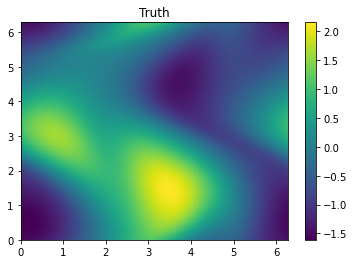

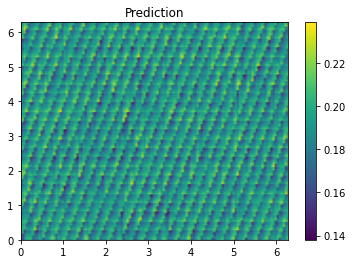

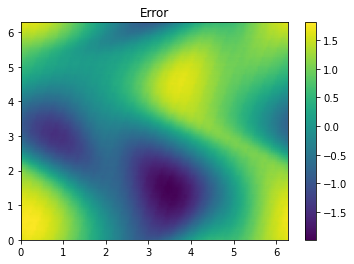

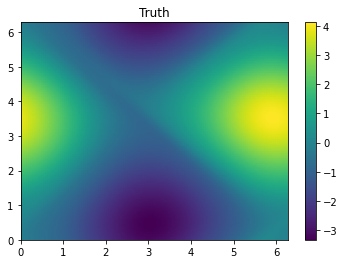

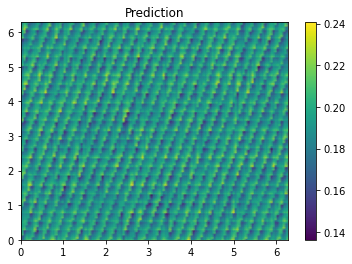

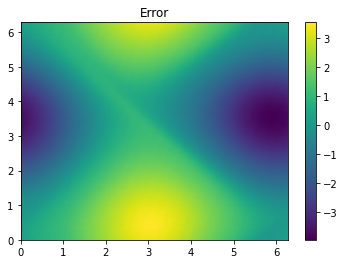

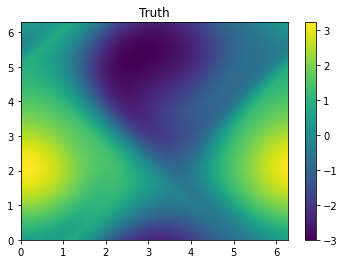

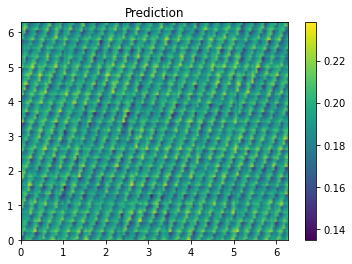

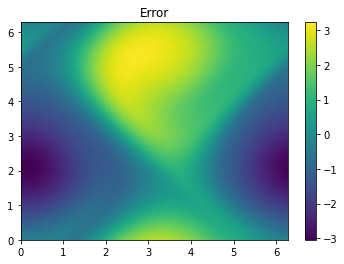

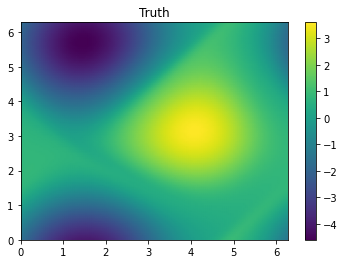

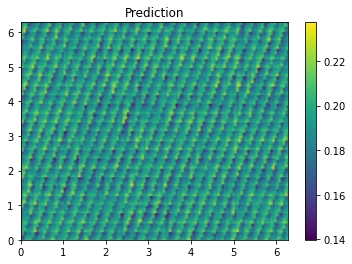

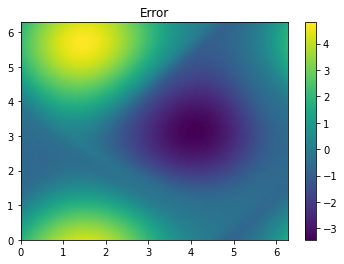

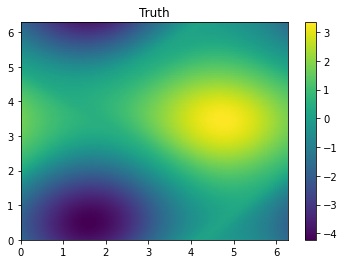

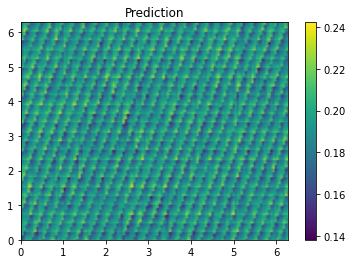

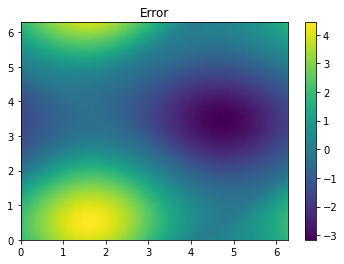

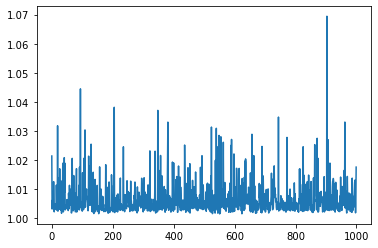

In [44]:
######################################################
N_θ, N_data  =  θ_test.shape
N_x, N_y, N_data = κ_test.shape


output_test = model(torch.from_numpy(input_test)).detach().numpy()
κ_pred = output_test.reshape(N_x, N_y, N_data)/coeff_scale


test_ids = np.arange(0, N_data)
errors = np.zeros(N_data)
for test_id in test_ids:

    errors[test_id] =  np.linalg.norm(κ_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if test_id %249 == 0:
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % test_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, test_id] - κ_test[:, :, test_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Average test error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)


